
=== Width w = 10 ===
 seed = 0
  -> compiling for h=2, w=10
  -> compiling for h=4, w=10
  -> compiling for h=6, w=10
  -> compiling for h=8, w=10
  -> compiling for h=10, w=10
  -> compiling for h=12, w=10
  -> compiling for h=14, w=10
  -> compiling for h=16, w=10
  -> compiling for h=18, w=10
  -> compiling for h=20, w=10
 seed = 1
  -> compiling for h=2, w=10
  -> compiling for h=4, w=10
  -> compiling for h=6, w=10
  -> compiling for h=8, w=10
  -> compiling for h=10, w=10
  -> compiling for h=12, w=10
  -> compiling for h=14, w=10
  -> compiling for h=16, w=10
  -> compiling for h=18, w=10
  -> compiling for h=20, w=10
 seed = 2
  -> compiling for h=2, w=10
  -> compiling for h=4, w=10
  -> compiling for h=6, w=10
  -> compiling for h=8, w=10
  -> compiling for h=10, w=10
  -> compiling for h=12, w=10
  -> compiling for h=14, w=10
  -> compiling for h=16, w=10
  -> compiling for h=18, w=10
  -> compiling for h=20, w=10
 seed = 3
  -> compiling for h=2, w=10
  -> compiling for h=

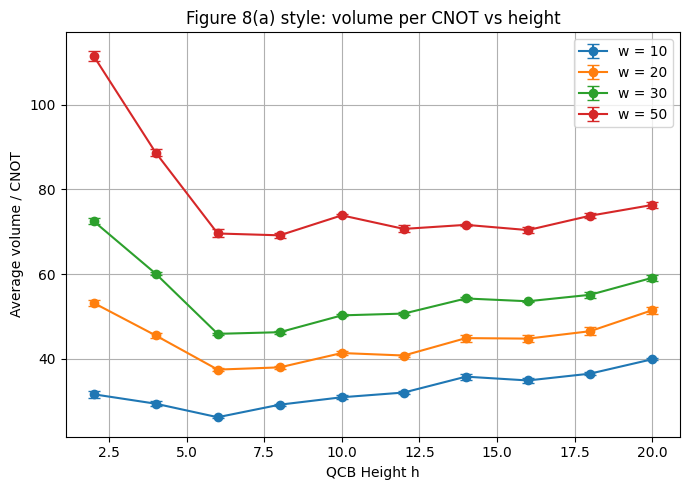

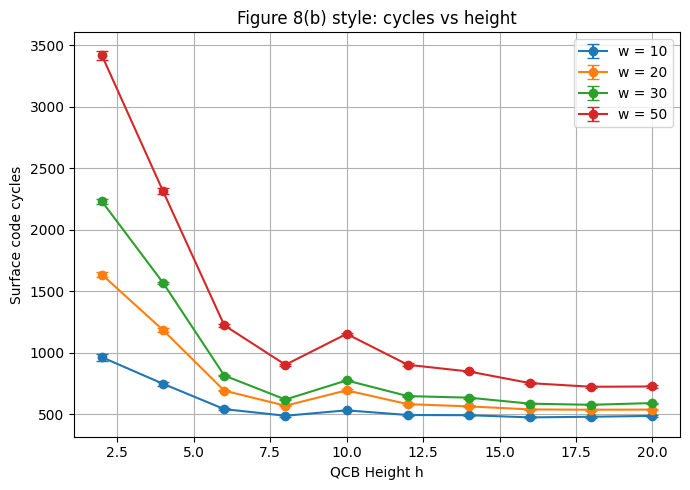

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from surface_code_routing.dag import DAG
from surface_code_routing.instructions import INIT, CNOT
from surface_code_routing.compiled_qcb import compile_qcb


# ---------------------------
# 1. ランダム CNOT ネットワーク（論文定義通り）
# ---------------------------
def build_random_cnot_dag(width_w: int, n_rounds: int, seed: int) -> DAG:
    """
    width_w: レジスタ本数 = QCB の width w と一致
    各ラウンド:
      - 0..w-1 をランダム permutation
      - (perm[0], perm[1]), (perm[2], perm[3]), ... で CNOT
      - 各レジスタは 1回だけ CNOT に参加
    """
    rng = np.random.default_rng(seed)
    dag = DAG(f"RandomCNOT_w{width_w}_R{n_rounds}_S{seed}")

    # INIT 全レジスタ
    for q in range(width_w):
        dag.add_gate(INIT(f"q_{q}"))

    for r in range(n_rounds):
        perm = rng.permutation(width_w)
        for i in range(0, width_w - 1, 2):
            ctrl = perm[i]
            targ = perm[i + 1]
            dag.add_gate(CNOT(f"q_{ctrl}", f"q_{targ}"))

    return dag


# ---------------------------
# 2. 単一 DAG をいろんな (h, w) に埋めてコンパイル
# ---------------------------
def compile_for_sizes(dag: DAG, heights, width_w, teleport=True):
    """
    同じ logical circuit（dag）を height だけ変えた QCB に埋める。
    width は固定で width_w。
    """
    results = []

    for h in heights:
        print(f"  -> compiling for h={h}, w={width_w}")
        compiled = compile_qcb(
            dag,
            height=h,
            width=width_w,
            router_kwargs={"teleport": teleport},
        )
        cycles = compiled.n_cycles()
        volume = compiled.space_time_volume()
        results.append((h, cycles, volume))

    return results


# ---------------------------
# 3. Figure 8 全体のベンチマーク
# ---------------------------
def benchmark_figure8_from_paper(
    widths=(10, 20, 30, 50),
    heights=range(2, 21, 2),   # h = 2,4,...,20
    n_rounds=100,              # Figure 8: 100 rounds
    seeds=range(5),            # 複数 seed 平均
):
    """
    論文の Figure 8 に合わせたベンチ:
      - 各 width w について:
        - 複数 seed で random CNOT network を生成
        - 各 seed 回路を、全ての height h に埋めてコンパイル
      - 結果:
        - volume_per_cnot(h, w) の平均と標準偏差
        - cycles(h, w) の平均と標準偏差
    """
    all_data = {}

    for w in widths:
        print(f"\n=== Width w = {w} ===")
        per_h_cycles = {h: [] for h in heights}
        per_h_volume_per_cnot = {h: [] for h in heights}

        # 1 seed = 1 logical circuit
        for seed in seeds:
            print(f" seed = {seed}")
            dag = build_random_cnot_dag(width_w=w, n_rounds=n_rounds, seed=seed)

            compiled_results = compile_for_sizes(dag, heights=heights, width_w=w)

            # 1ラウンドあたり w/2 個の CNOT
            n_cnot_per_round = w // 2
            total_cnot = n_rounds * n_cnot_per_round

            for (h, cycles, volume) in compiled_results:
                per_h_cycles[h].append(cycles)
                per_h_volume_per_cnot[h].append(volume / total_cnot)

        # 平均・標準偏差を計算
        h_vals = sorted(heights)
        mean_cycles = [np.mean(per_h_cycles[h]) for h in h_vals]
        std_cycles = [np.std(per_h_cycles[h]) for h in h_vals]
        mean_vol_per_cnot = [np.mean(per_h_volume_per_cnot[h]) for h in h_vals]
        std_vol_per_cnot = [np.std(per_h_volume_per_cnot[h]) for h in h_vals]

        all_data[w] = {
            "h": h_vals,
            "mean_cycles": mean_cycles,
            "std_cycles": std_cycles,
            "mean_vol_per_cnot": mean_vol_per_cnot,
            "std_vol_per_cnot": std_vol_per_cnot,
        }

    return all_data


# ---------------------------
# 4. Figure 8(a)(b) のプロット
# ---------------------------
def plot_figure8_style(all_data, widths=(10, 20, 30, 50)):
    # (a) Volume / CNOT vs h
    plt.figure(figsize=(7, 5))
    for w in widths:
        d = all_data[w]
        plt.errorbar(
            d["h"],
            d["mean_vol_per_cnot"],
            yerr=d["std_vol_per_cnot"],
            fmt="-o",
            capsize=4,
            label=f"w = {w}",
        )
    plt.xlabel("QCB Height h")
    plt.ylabel("Average volume / CNOT")
    plt.title("Figure 8(a) style: volume per CNOT vs height")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("figure8a_volume_per_cnot.png", dpi=200)

    # (b) Cycles vs h
    plt.figure(figsize=(7, 5))
    for w in widths:
        d = all_data[w]
        plt.errorbar(
            d["h"],
            d["mean_cycles"],
            yerr=d["std_cycles"],
            fmt="-o",
            capsize=4,
            label=f"w = {w}",
        )
    plt.xlabel("QCB Height h")
    plt.ylabel("Surface code cycles")
    plt.title("Figure 8(b) style: cycles vs height")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("figure8b_cycles.png", dpi=200)

    print("Saved: figure8a_volume_per_cnot.png, figure8b_cycles.png")


# ---------------------------
# 5. エントリポイント
# ---------------------------
if __name__ == "__main__":
    WIDTHS = (10, 20, 30, 50)
    HEIGHTS = range(2, 21, 2)     # h = 2,4,...,20
    N_ROUNDS = 100
    SEEDS = range(5)

    data = benchmark_figure8_from_paper(
        widths=WIDTHS,
        heights=HEIGHTS,
        n_rounds=N_ROUNDS,
        seeds=SEEDS,
    )

    plot_figure8_style(data, widths=WIDTHS)
